In [21]:
from data_fetch import automobile_id, getTargets, getFeatures, missingValues
import data_transformation
import data_encoding
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
from dtuimldmtools import rlr_validate
from sklearn import model_selection
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    loglog,
    semilogx,
    show,
    subplot,
    title,
    xlabel,
    ylabel,
)

# Gather the data to be used
X_cat = data_encoding.encode(getFeatures(automobile_id)[['body-style']])
missing_values_cat = missingValues(X_cat)

X_num = data_transformation.transform(getFeatures(automobile_id)[['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']])
missing_values_num = missingValues(X_num)

missing_values = list(set(missing_values_num).union(set(missing_values_cat)))

X = pd.concat([X_num, X_cat], axis=1)
y = getTargets(automobile_id)

# Drop missing values
X = X.drop(missing_values)
y = y.drop(missing_values)



In [22]:
# Create the list of the attributes
attributeNames = list(X.columns)
print(attributeNames)


['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price', 'body-style_convertible', 'body-style_hardtop', 'body-style_hatchback', 'body-style_sedan', 'body-style_wagon']


In [23]:
# Change X and y to numpy arrays
X = X.to_numpy()
y = y.to_numpy()

In [24]:
# Change the data to float32
X = X.astype('float32')
y = y.astype('float32')

# Standardize the data
X = (X - X.mean(axis=0)) / X.std(axis=0)

N, M = X.shape


In [25]:
# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = ["Offset"] + attributeNames
M = M + 1

In [26]:
## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(K, shuffle=True)
# CV = model_selection.KFold(K, shuffle=False)

In [27]:
# Values of lambda
lambdas = np.power(10.0, range(-5, 9))

In [28]:
# Initialize variables
# T = len(lambdas)
Error_train = np.zeros((K, 1))
Error_test = np.zeros((K, 1))
Error_train_rlr = np.zeros((K, 1))
Error_test_rlr = np.zeros((K, 1))
Error_train_nofeatures = np.zeros((K, 1))
Error_test_nofeatures = np.zeros((K, 1))
w_rlr = np.zeros((M, K))
mu = np.zeros((K, M - 1))
sigma = np.zeros((K, M - 1))
w_noreg = np.zeros((M, K))

/Users/maxfavrot/anaconda3/envs/my_environment/lib/python3.11/site-packages/dtuimldmtools/crossvalidation/implementations.py:138: RuntimeWarning: invalid value encountered in divide
  X_train[:, 1:] = (X_train[:, 1:] - mu) / sigma
/Users/maxfavrot/anaconda3/envs/my_environment/lib/python3.11/site-packages/dtuimldmtools/crossvalidation/implementations.py:139: RuntimeWarning: divide by zero encountered in divide
  X_test[:, 1:] = (X_test[:, 1:] - mu) / sigma
/Users/maxfavrot/anaconda3/envs/my_environment/lib/python3.11/site-packages/dtuimldmtools/crossvalidation/implementations.py:139: RuntimeWarning: invalid value encountered in divide
  X_test[:, 1:] = (X_test[:, 1:] - mu) / sigma


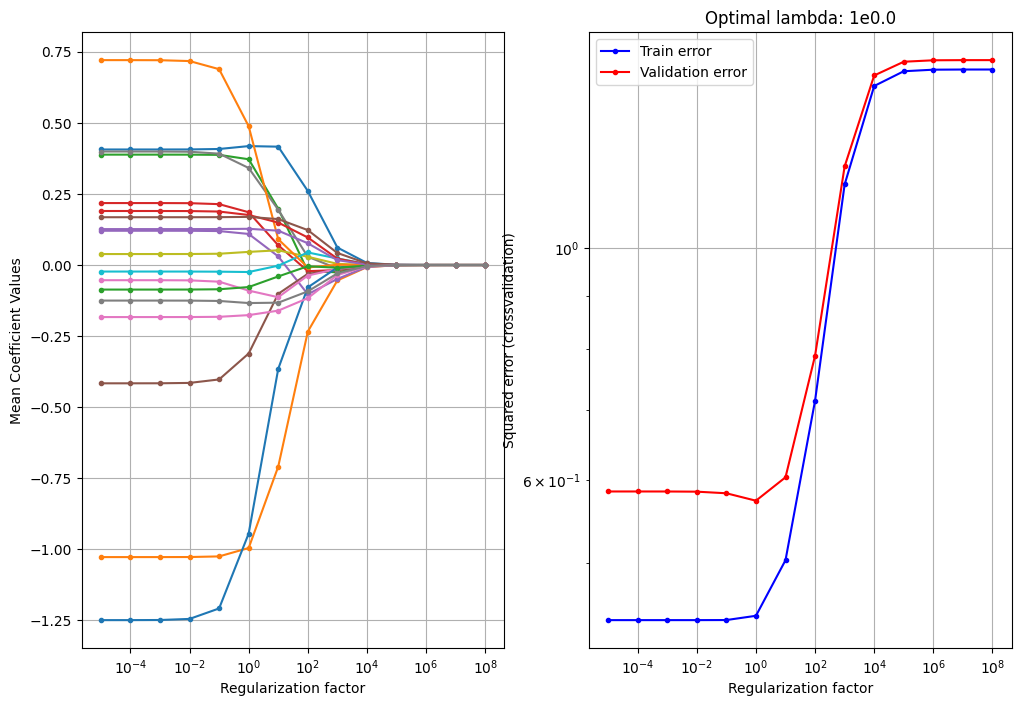

In [29]:
k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k].reshape(M, 1)).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k].reshape(M, 1)).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k].reshape(M, 1)).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k].reshape(M, 1)).sum(axis=0) / y_test.shape[0]
    )
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    # m = lm.LinearRegression().fit(X_train, y_train)
    # Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    # Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K - 1:
        figure(k, figsize=(12, 8))
        subplot(1, 2, 1)
        semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
        xlabel("Regularization factor")
        ylabel("Mean Coefficient Values")
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner
        # plot, since there are many attributes
        # legend(attributeNames[1:], loc='best')

        subplot(1, 2, 2)
        title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        xlabel("Regularization factor")
        ylabel("Squared error (crossvalidation)")
        legend(["Train error", "Validation error"])
        grid()

    # To inspect the used indices, use these print statements
    # print('Cross validation fold {0}/{1}:'.format(k+1,K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}\n'.format(test_index))

    k += 1

In [30]:
show()
# Display results
print("Linear regression without feature selection:")
print("- Training error: {0}".format(Error_train.mean()))
print("- Test error:     {0}".format(Error_test.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum()
    )
)
print("Regularized linear regression:")
print("- Training error: {0}".format(Error_train_rlr.mean()))
print("- Test error:     {0}".format(Error_test_rlr.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train_rlr.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test_rlr.sum())
        / Error_test_nofeatures.sum()
    )
)

print("Weights in last fold:")
for m in range(M):
    print("{:>15} {:>15}".format(attributeNames[m], np.round(w_rlr[m, -1], 2)))




Linear regression without feature selection:
- Training error: 0.4452566627867987
- Test error:     0.5790041165734048
- R^2 train:     0.701860457381428
- R^2 test:     0.6117145544793173

Regularized linear regression:
- Training error: 0.44698206490529746
- Test error:     0.5680537223253633
- R^2 train:     0.700705144858483
- R^2 test:     0.6190579888134131

Weights in last fold:
         Offset             0.8
normalized-losses            0.42
     wheel-base            -1.0
         length            0.38
          width            0.18
         height            0.11
    curb-weight           -0.32
    engine-size           -0.09
compression-ratio            0.34
     horsepower            0.04
       peak-rpm           -0.03
       city-mpg           -0.97
    highway-mpg             0.5
          price           -0.08
body-style_convertible            0.18
body-style_hardtop            0.13
body-style_hatchback            0.17
body-style_sedan           -0.18
body-style_wago